# Part 1: Real-Time Data Collection & Preprocessing

<ipython-input-2-4e2afe6c5046>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-2-4e2afe6c5046>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


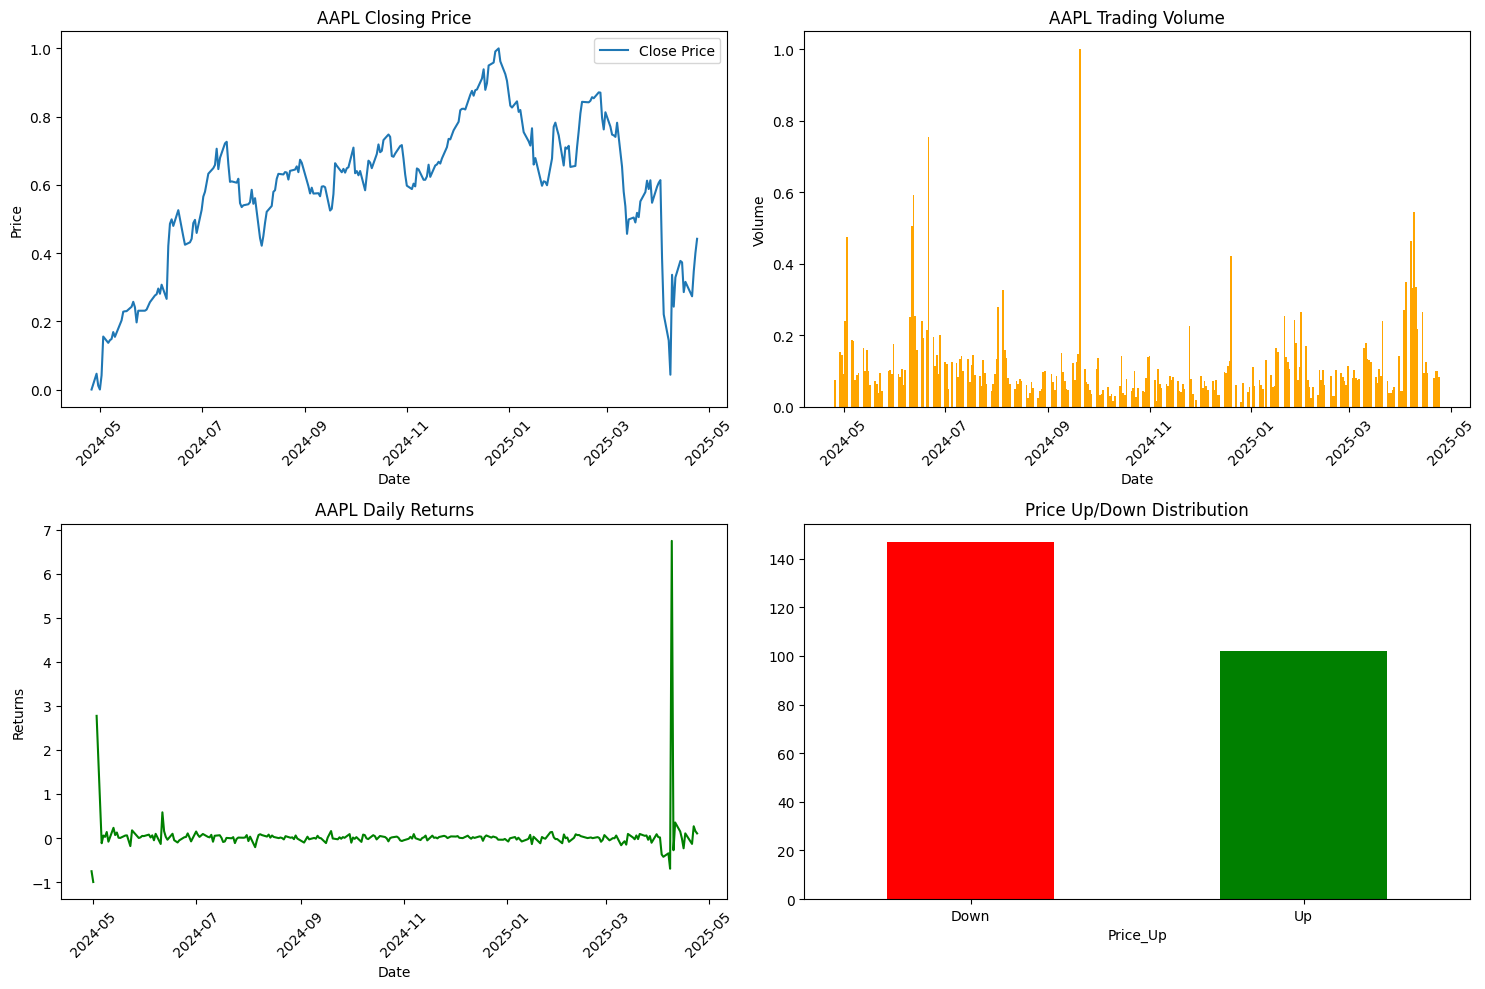

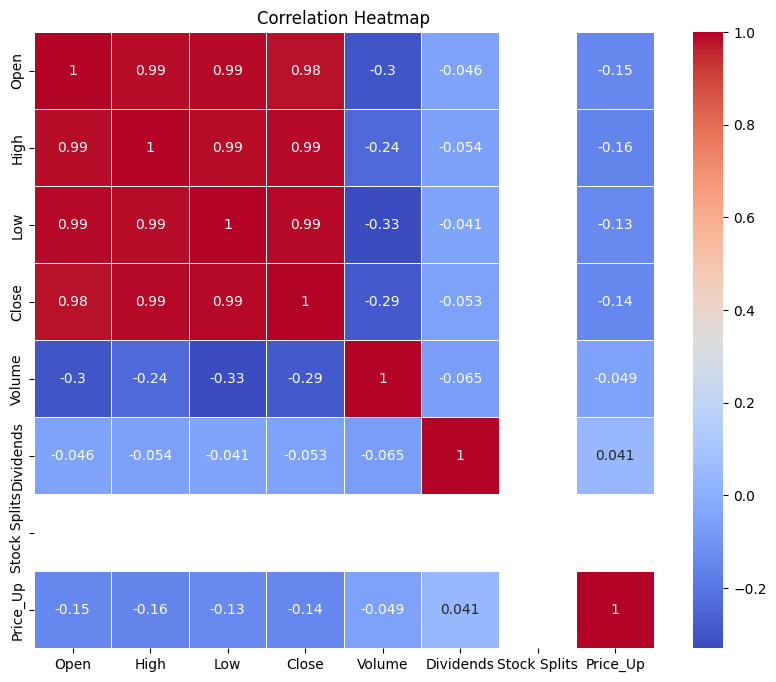

In [ ]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Fetch stock data
def fetch_stock_data(ticker, period='1y'):
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    return df

# Preprocess data
def preprocess_data(df):
    # Handle missing values
    df.fillna(method='ffill', inplace=True)

    # Create target variable for classification (1 if price increased, 0 otherwise)
    df['Price_Up'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    # Drop the last row as we don't know the next day's movement
    df = df[:-1]

    # Normalize the data
    scaler = MinMaxScaler()
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df, scaler

#visualization
def visualize_data(df, ticker):
    plt.figure(figsize=(15, 10))

    # Convert index to datetime if it isn't already
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # 1. Price trends
    plt.subplot(2, 2, 1)
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.title(f'{ticker} Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)  # Rotate dates for readability
    plt.legend()

    # 2. Volume analysis
    plt.subplot(2, 2, 2)
    plt.bar(df.index, df['Volume'], color='orange', width=1)  # Width helps with bar spacing
    plt.title(f'{ticker} Trading Volume')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.xticks(rotation=45)

    # 3. Daily price changes
    plt.subplot(2, 2, 3)
    daily_returns = df['Close'].pct_change()
    plt.plot(df.index, daily_returns, label='Daily Returns', color='green')
    plt.title(f'{ticker} Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.xticks(rotation=45)

    # 4. Price Up/Down distribution
    plt.subplot(2, 2, 4)
    # Ensure you have this column - you might need: df['Price_Up'] = (df['Close'].diff() > 0).astype(int)
    df['Price_Up'].value_counts().plot(kind='bar', color=['red', 'green'])
    plt.title('Price Up/Down Distribution')
    plt.xticks([0, 1], ['Down', 'Up'], rotation=0)

    plt.tight_layout()  # Adjusts spacing between subplots
    plt.show()  # Only call show() once at the end

    # Correlation heatmap (separate figure)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

# Example usage
ticker = 'AAPL'  # Apple stock
df = fetch_stock_data(ticker)
df, scaler = preprocess_data(df)
visualize_data(df, ticker)

# Part 2: Stock Classification - Predicting Price Movement

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for classification
def prepare_classification_data(df, look_back=10):
    X, y = [], []
    for i in range(len(df) - look_back - 1):
        features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values[i:i+look_back]
        target = df['Price_Up'].values[i+look_back]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)

# Create MLP model
def create_mlp(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create SimpleRNN model
def create_simplernn(input_shape):
    model = Sequential([
        SimpleRNN(50, return_sequences=True, input_shape=input_shape),
        SimpleRNN(50),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create LSTM model
def create_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    print(classification_report(y_test, y_pred))

    # ROC curve
    y_pred_prob = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return y_pred


# Part 3: Stock Regression - Stock Price Prediction - Next Day Price

In [ ]:
from sklearn.metrics import mean_squared_error

# Prepare data for regression
def prepare_regression_data(df, look_back=10):
    X, y = [], []
    for i in range(len(df) - look_back - 1):
        features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values[i:i+look_back]
        target = df['Close'].values[i+look_back]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)

# Create MLP regression model
def create_mlp_regression(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create SimpleRNN regression model
def create_simplernn_regression(input_shape):
    model = Sequential([
        SimpleRNN(50, return_sequences=True, input_shape=input_shape),
        SimpleRNN(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create LSTM regression model
def create_lstm_regression(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Evaluate regression model
def evaluate_regression_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse transform if data was normalized
    if scaler:
        # Create dummy array with 5 columns to match scaler's expectations
        dummy_test = np.zeros((len(y_test), 5))
        dummy_test[:, 3] = y_test  # Close price is the 4th column (index 3)
        dummy_test = scaler.inverse_transform(dummy_test)
        y_test = dummy_test[:, 3]

        dummy_pred = np.zeros((len(y_pred), 5))
        dummy_pred[:, 3] = y_pred.reshape(-1)
        dummy_pred = scaler.inverse_transform(dummy_pred)
        y_pred = dummy_pred[:, 3]

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")


    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual Price')
    plt.plot(y_pred, label='Predicted Price')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return y_pred, mse, rmse


Classification Models


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training MLP model...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5595 - loss: 0.7388 - val_accuracy: 0.7368 - val_loss: 0.6678
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5312 - loss: 0.7007 - val_accuracy: 0.5789 - val_loss: 0.6895
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6532 - loss: 0.6804 - val_accuracy: 0.7368 - val_loss: 0.6570
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6077 - loss: 0.6872 - val_accuracy: 0.7368 - val_loss: 0.6421
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5803 - loss: 0.6764 - val_accuracy: 0.7368 - val_loss: 0.6376
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6128 - loss: 0.6737 - val_accuracy: 0.7368 - val_loss: 0.6397
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5694 - loss: 0.6823 - val_accuracy: 0.7368 - val_loss: 0.6580
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5456 - loss: 0.6787 - val_accu

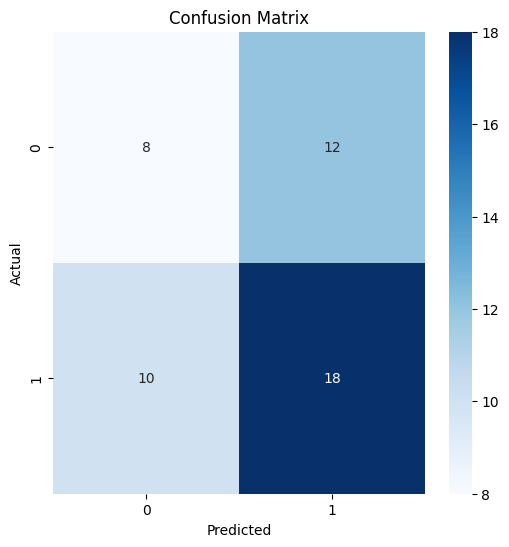

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        20
           1       0.60      0.64      0.62        28

    accuracy                           0.54        48
   macro avg       0.52      0.52      0.52        48
weighted avg       0.54      0.54      0.54        48

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


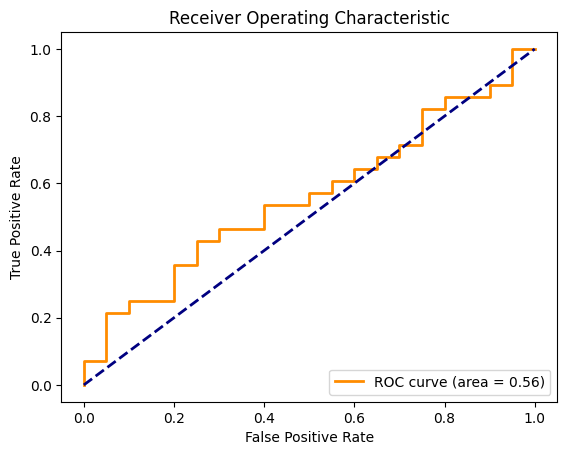


Training SimpleRNN model...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5266 - loss: 0.6871 - val_accuracy: 0.6842 - val_loss: 0.6323
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5815 - loss: 0.6687 - val_accuracy: 0.7368 - val_loss: 0.6318
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5867 - loss: 0.6697 - val_accuracy: 0.7368 - val_loss: 0.5898
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5793 - loss: 0.6698 - val_accuracy: 0.6842 - val_loss: 0.6538
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5407 - loss: 0.6665 - val_accuracy: 0.7368 - val_loss: 0.6356
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6151 - loss: 0.6490 - val_accuracy: 0.7368 - val_loss: 0.6219
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5362 - loss: 0.6686 - val_accuracy: 0.4211 - val_loss: 0.6954
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6478 - loss: 0.6471 - va

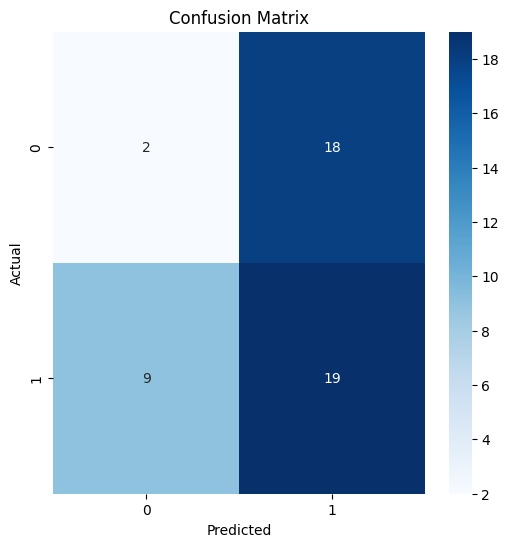

              precision    recall  f1-score   support

           0       0.18      0.10      0.13        20
           1       0.51      0.68      0.58        28

    accuracy                           0.44        48
   macro avg       0.35      0.39      0.36        48
weighted avg       0.38      0.44      0.39        48

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


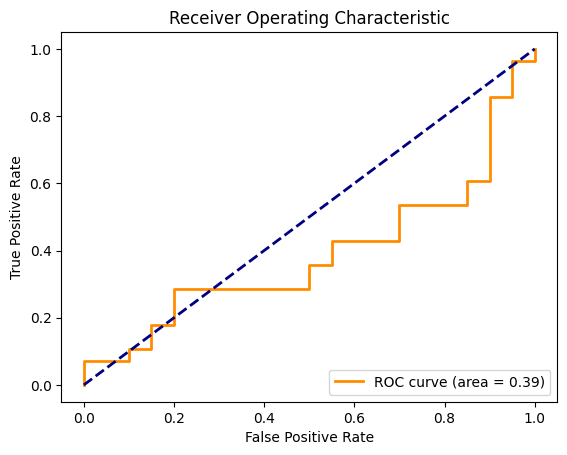


Training LSTM model...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.5126 - loss: 0.6910 - val_accuracy: 0.7368 - val_loss: 0.6426
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5460 - loss: 0.6956 - val_accuracy: 0.7368 - val_loss: 0.6432
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5929 - loss: 0.6804 - val_accuracy: 0.7368 - val_loss: 0.6368
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5686 - loss: 0.6868 - val_accuracy: 0.7368 - val_loss: 0.6394
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5872 - loss: 0.6782 - val_accuracy: 0.7368 - val_loss: 0.6520
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5555 - loss: 0.6873 - val_accuracy: 0.7368 - val_loss: 0.6684
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6041 - loss: 0.6793 - val_accuracy: 0.7368 - val_loss: 0.6424
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5756 - loss: 0.6784 - val_acc

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step


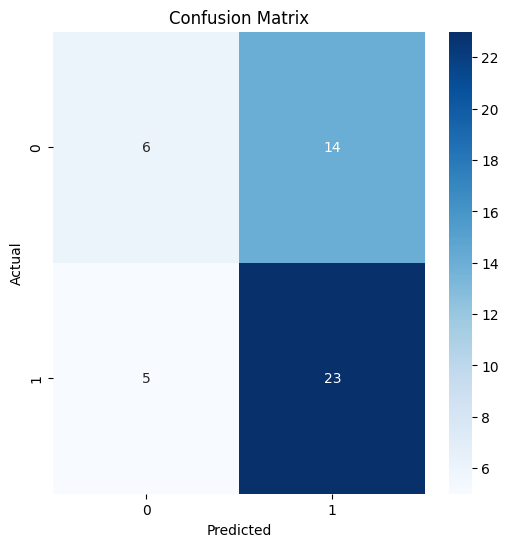

              precision    recall  f1-score   support

           0       0.55      0.30      0.39        20
           1       0.62      0.82      0.71        28

    accuracy                           0.60        48
   macro avg       0.58      0.56      0.55        48
weighted avg       0.59      0.60      0.57        48

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


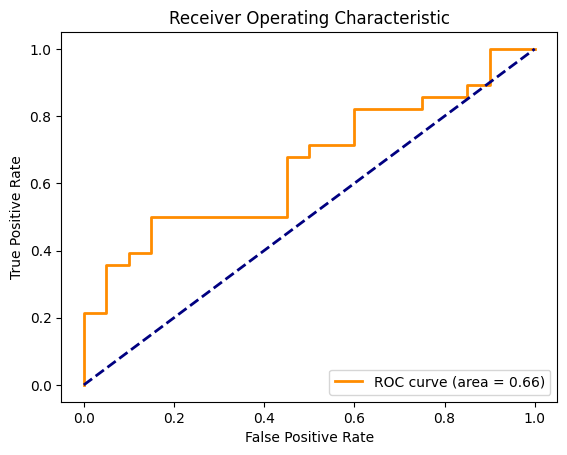

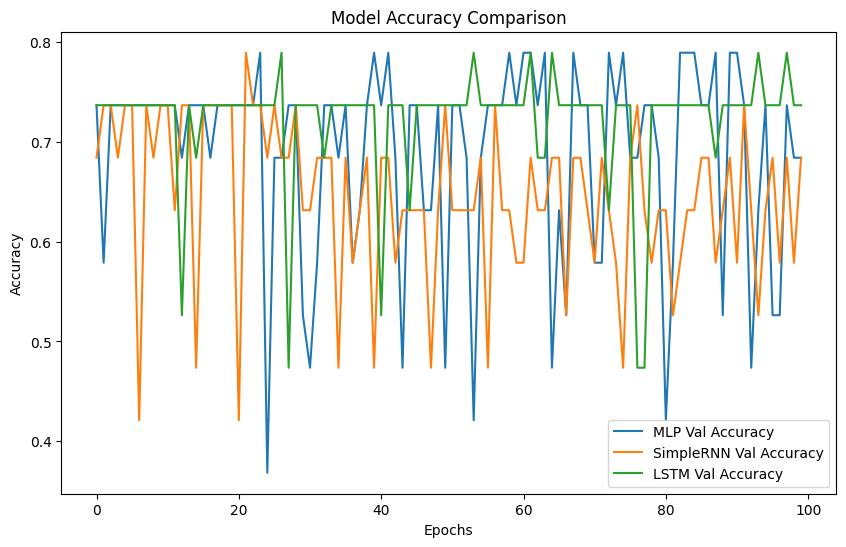

Regression Models

Training MLP model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3284 - val_loss: 0.0320
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0528 - val_loss: 0.0304
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0652 - val_loss: 0.0098
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0301 - val_loss: 0.0109
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0373 - val_loss: 0.0123
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0304 - val_loss: 0.0048
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0181 - val_loss: 0.0069
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0257 - val_loss: 0.0072
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0235 - val_loss: 0.0046
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208 - val_loss: 0.0046
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0160 - val_loss: 0.0047
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0200 - val_loss: 0.0046
E

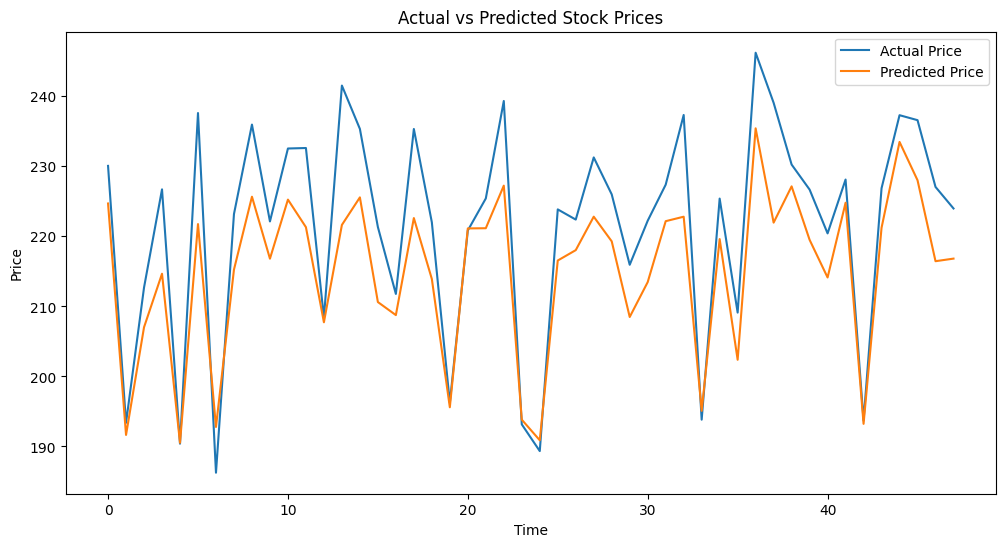


Training SimpleRNN model...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.2200 - val_loss: 0.0675
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0863 - val_loss: 0.0674
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0367 - val_loss: 0.0105
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0240 - val_loss: 0.0120
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0127 - val_loss: 0.0036
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0078 - val_loss: 0.0033
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23m

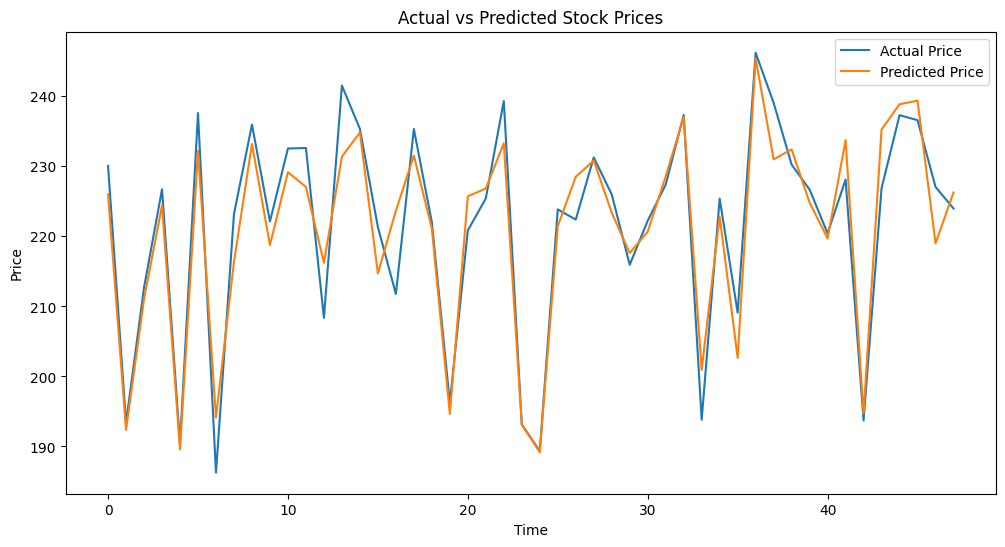


Training LSTM model...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.3935 - val_loss: 0.0591
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0404 - val_loss: 0.0529
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0531 - val_loss: 0.0112
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0152 - val_loss: 0.0083
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0157 - val_loss: 0.0060
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0123 - val_loss: 0.0058
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0095 - val_loss: 0.0053
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0084 - val_loss: 0.0056
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0085 - val_loss: 0.0057
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/ste

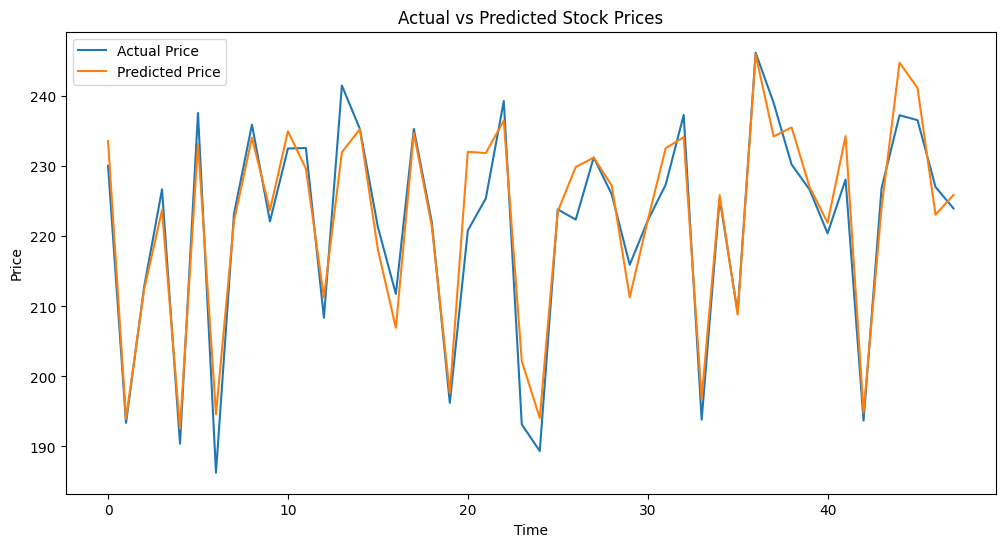

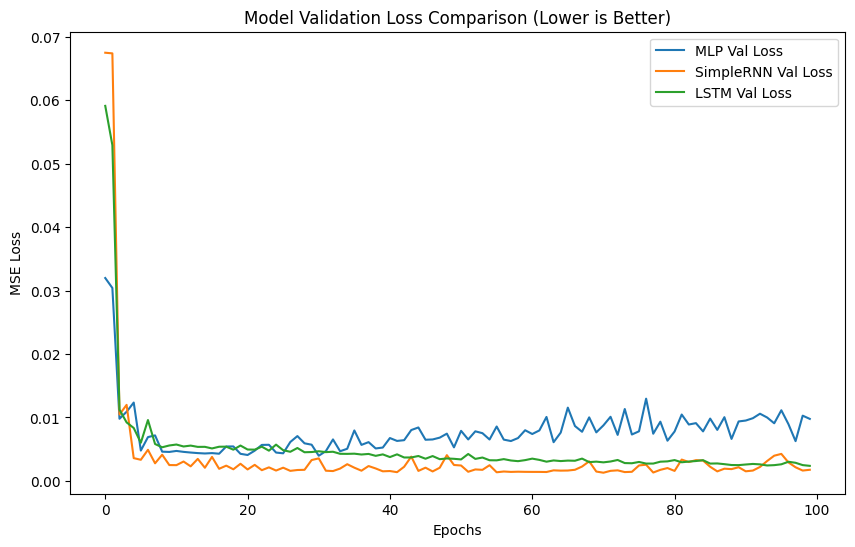

All models and scaler saved successfully!


In [ ]:

def run_classification(df):
    look_back = 10
    X, y = prepare_classification_data(df, look_back)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape for MLP
    X_train_mlp = X_train.reshape(X_train.shape[0], -1)
    X_test_mlp = X_test.reshape(X_test.shape[0], -1)
    input_shape_mlp = (X_train_mlp.shape[1],)

    # Models
    models = {
        'MLP': create_mlp(input_shape_mlp),
        'SimpleRNN': create_simplernn((look_back, 5)),
        'LSTM': create_lstm((look_back, 5))
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name} model...")
        if name == 'MLP':
            history = model.fit(X_train_mlp, y_train, epochs=100, batch_size=32,
                             validation_split=0.1, verbose=1)
            y_pred = evaluate_model(model, X_test_mlp, y_test)
        else:
            history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                             validation_split=0.1, verbose=1)
            y_pred = evaluate_model(model, X_test, y_test)

        # Store both the model and history in results
        results[name] = {
            'model': model,  # Store the actual model
            'history': history.history,  # Store training history
            'y_pred': y_pred
        }

    # Compare model accuracies
    plt.figure(figsize=(10, 6))
    for name, result in results.items():
        plt.plot(result['history']['val_accuracy'], label=f'{name} Val Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


    return results



# Similarly modify run_regression():
def run_regression(df, scaler):
    look_back = 10
    X, y = prepare_regression_data(df, look_back)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape for MLP
    X_train_mlp = X_train.reshape(X_train.shape[0], -1)
    X_test_mlp = X_test.reshape(X_test.shape[0], -1)
    input_shape_mlp = (X_train_mlp.shape[1],)

    # Models
    models = {
        'MLP': create_mlp_regression(input_shape_mlp),
        'SimpleRNN': create_simplernn_regression((look_back, 5)),
        'LSTM': create_lstm_regression((look_back, 5))
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name} model...")
        if name == 'MLP':
            history = model.fit(X_train_mlp, y_train, epochs=100, batch_size=32,
                             validation_split=0.1, verbose=1)
            y_pred, mse, rmse = evaluate_regression_model(model, X_test_mlp, y_test, scaler)
        else:
            history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                             validation_split=0.1, verbose=1)
            y_pred, mse, rmse = evaluate_regression_model(model, X_test, y_test, scaler)

        # Store both the model and history in results
        results[name] = {
            'model': model,  # Store the actual model
            'history': history.history,  # Store training history
            'y_pred': y_pred,
            'mse': mse,
            'rmse': rmse
        }

    # Compare model performance
    plt.figure(figsize=(10, 6))
    for name, result in results.items():
        plt.plot(result['history']['val_loss'], label=f'{name} Val Loss')
    plt.title('Model Validation Loss Comparison (Lower is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()


    return results


print("Classification Models")
classification_results = run_classification(df)
print("Regression Models")
regression_results = run_regression(df, scaler)

# save the models - this will now work correctly
import joblib
from tensorflow.keras.models import save_model

# Save classification models
for name, result in classification_results.items():
    save_model(result['model'], f'{name.lower()}_classification.h5')

# Save regression models
for name, result in regression_results.items():
    save_model(result['model'], f'{name.lower()}_regression.h5')

# Save scaler
joblib.dump(scaler, 'scaler.save')

print("All models and scaler saved successfully!")

In [ ]:
from google.colab import files
import zipfile
import os

# List of files to download
file_list = [
    'mlp_classification.h5',
    'simplernn_classification.h5',
    'lstm_classification.h5',
    'mlp_regression.h5',
    'simplernn_regression.h5',
    'lstm_regression.h5',
    'scaler.save'
]

# Create a zip file containing all files
zip_filename = 'stock_models.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in file_list:
        if os.path.exists(file):
            zipf.write(file)

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>